# Interface residue ML prediction. Fourth attempt, add distance and convolve or pool over (points * features)
It is clear that distance is a useful feature that increases prediction accuracy. Perhaps this can be leveraged by not flattening the input features right away with `x.view()` . This maintains the points(e.g. 20) * features (27) structure of the data and should reflect the fact that a given feature is only a relevant description of one point.

## Load modules and packages

In [1]:
from sklearn import tree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

from sklearn import datasets
from sklearn.decomposition import PCA
import random

In [3]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

## Load data, standard dictionaries and lists
Also:
- Removes empty columns from One-hot encoded target array. (Some standard residues in dict and list do not occur in dataset)
- Store an int version of One-hot encoded target array.
- Scale input features
- Split in training and test sets

In [4]:
res2num = {"ALA": 0, "ASX": 1, "CYS": 2, "ASP": 3, "GLU": 4, "PHE": 5, "GLY": 6, "HIS": 7,
 "ILE": 8, "LYS": 9, "LEU": 10, "MET": 11, "ASN": 12, "PRO": 13, "GLN": 14,
  "ARG": 15, "SER": 16, "THR": 17, "SEC": 18, "VAL": 19, "TRP": 20, "XAA": 21,
   "TYR": 22, "GLX": 23}

old_names = ["ALA", "ASX", "CYS", "ASP", "GLU", "PHE", "GLY", "HIS",
 "ILE", "LYS", "LEU", "MET", "ASN", "PRO", "GLN",
  "ARG", "SER", "THR", "SEC", "VAL", "TRP", "XAA",
   "TYR", "GLX"]

In [6]:
# Load features and targets
X = np.load('../dataset/angle_train_data.npy')
X_old = X

y = np.load('../dataset/angle_train_target.npy')

# Select non zero from old_names using y first
nonzero_index = (~np.all(y == 0, axis = 0)).nonzero()[0]
names = []
for i in nonzero_index:
    names.append(old_names[i])
    
# Then remove zero columns from 'y'
y = y[:,~np.all(y == 0, axis = 0)]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_old)
X = X_scaled.reshape(41656, 20, 28)

In [9]:
# Just check the ranges of features
feature_count =0
for i in range(X.shape[-1]):
    print(feature_count, np.min(X[:,:,i]), np.max(X[:,:,i]))
    feature_count+=1

0 -5.562427400662694 2.99891051214725
1 -8.364638508995272 6.151245091397315
2 -6.090247843178873 3.4817497807998916
3 -13.54360192022185 6.572809436490604
4 -5.370522390426154 5.659253587086887
5 -16.92221305611832 13.592488620772832
6 -5.344516515779994 7.219357502187148
7 -11.313166110727783 16.540525192622425
8 -3.468937447290468 6.650238701779665
9 -5.995025548848426 9.51520847826829
10 -4.5904749720187 4.234839674908006
11 -4.479463909668845 3.259281516632538
12 -4.277021963590009 4.3249667604225035
13 -3.8863760549414783 5.514392041874248
14 -2.6909536454899925 3.408133594263995
15 -4.989437976671926 4.307363246561126
16 -8.55429771886772 3.9738221086591814
17 -9.048641649082402 4.709183027410861
18 -6.921036501470965 4.75799313498063
19 -5.495051909009567 6.055822946435239
20 -7.023376702389171 6.1962552939382745
21 -7.94136588207135 5.019294298662959
22 -3.987616003741541 6.031039504674115
23 -4.89632061587742 6.927229502926768
24 -0.0 -0.0
25 -0.8757605390399092 1.39043682176

In [10]:
# Get integer values from one-hot encoding
y_int = np.array([])
for i in y:
    y_int = np.concatenate((y_int, np.nonzero(i)[0]))

# Save float and unique arrays of y_int
y_float = y_int.astype(np.float32)
unique_y = np.unique(y_float)

In [11]:
# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y_float, test_size=0.2, random_state=2)

In [13]:
X_temp_train = X_train.reshape(X_train.shape[0],560)
X_temp_test = X_test.reshape(X_test.shape[0],560)

## Basic EDA and visualisation
Can a simple tree-based machine learning algorithm predict the residue?

Can PCA or t-SNE already find a separation between data points? I.e., is there something distinguishing the point clouds complementary to residues that does not have to be "learned" during multiple irations?

Furthermore, what how frequently do the respective residue types occur at interfaces? One needs to deal with imbalances in the dataset.

In [14]:
X_temp_test.shape

(8332, 560)

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=15, random_state=0, class_weight= "balanced")
clf.fit(X_temp_train, y_train)

y_RF_pred = clf.predict(X_temp_test)

In [16]:
len(np.unique(y_RF_pred))

20

''

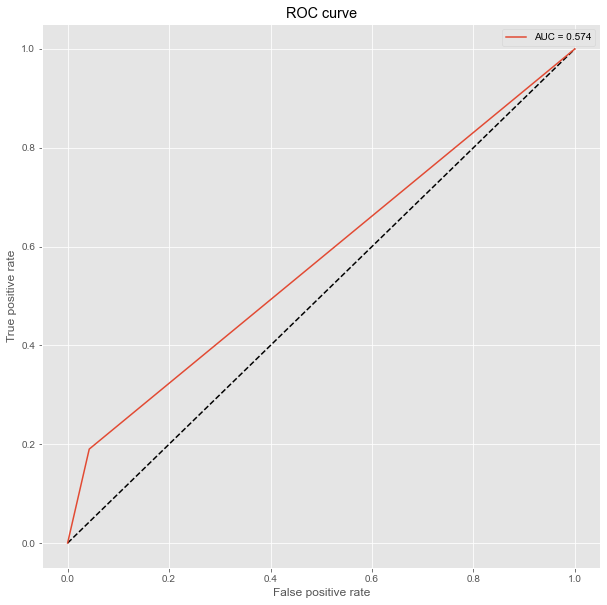

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()
y_RF_onehot = enc.fit_transform(y_RF_pred[:, np.newaxis]).toarray()
with torch.no_grad():
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_RF_onehot.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
sns.set_style("whitegrid")
;

In [18]:
pca = PCA(n_components=2)
X_r = pca.fit(X_scaled).transform(X_scaled)

print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

explained variance ratio (first two components): [0.20230084 0.08742544]


In [19]:
rgb = []
for y in unique_y:
    col = (random.random(), random.random(), random.random())
    rgb.append(col)
colors = rgb

In [20]:
plt.figure()
lw = 2

<Figure size 432x288 with 0 Axes>

In [21]:
num2res = dict(zip(range(len(names)), names))
y_res_str = pd.Series(y_float).map(lambda x: num2res[x])

'Amino acid counts'

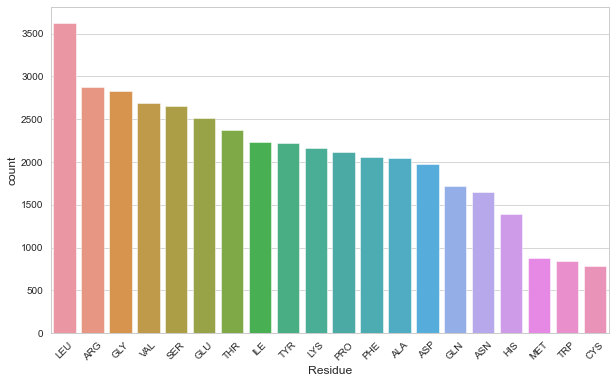

In [22]:
import seaborn as sns
plt.figure(figsize = (10,6))
df = pd.DataFrame(y_res_str)
df.rename(columns={0:'Residue'}, inplace=True)
sns.countplot(x='Residue', data = df, order = y_res_str.value_counts().index)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)

g ="Amino acid counts"
g

Text(0.5, 1.0, 'PCA of AA surface dataset')

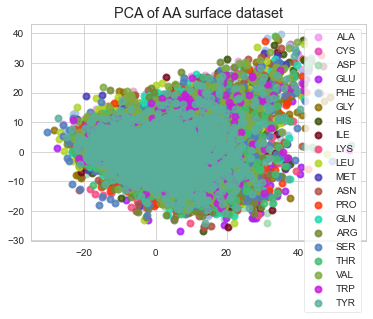

In [23]:
for color, i, name in zip(colors, unique_y, names[0:20]):
    plt.scatter(X_r[y_int == i, 0], X_r[y_int == i, 1], color = color, alpha=.8, lw=lw,
                label=name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of AA surface dataset')

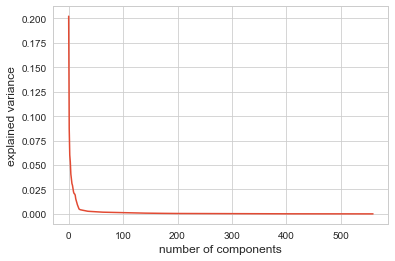

In [24]:
pca = PCA().fit(X_scaled)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('explained variance');

In [25]:
print(abs( pca.components_ ))

[[6.19419227e-02 5.81927935e-02 8.11107794e-02 ... 4.60812027e-03
  4.38203651e-02 5.59797317e-04]
 [6.66433968e-02 6.65908852e-02 5.03186029e-02 ... 4.20174840e-05
  2.94827893e-02 3.96649314e-03]
 [3.44606437e-02 3.02369971e-02 1.77890898e-02 ... 4.98041188e-05
  2.59513901e-02 1.59326588e-02]
 ...
 [0.00000000e+00 4.81884815e-17 1.02681881e-16 ... 2.88397778e-17
  1.68718799e-16 9.90689735e-18]
 [0.00000000e+00 1.67192321e-32 1.25086802e-31 ... 1.12426161e-32
  5.31135367e-32 7.16205198e-34]
 [0.00000000e+00 1.18820508e-16 1.14683267e-16 ... 7.84962373e-17
  9.21842897e-17 2.60750622e-17]]


In [26]:
# Add contibution of variables to two PC's and form a single array
contrib_arr = np.add(abs(pca.components_)[0], abs(pca.components_)[1])

In [27]:
contrib_arr.shape

(560,)

In [32]:
indices = (-abs(contrib_arr)).argsort()[:100]

In [33]:
(indices < 280).sum()

60

/Users/maxjansen/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

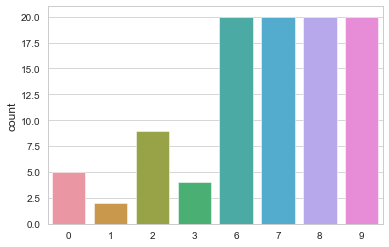

In [34]:
sns.countplot(indices%28)

<AxesSubplot:xlabel='Ranking', ylabel='Contribution'>

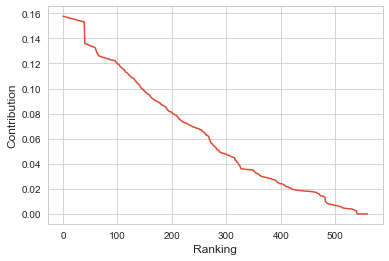

In [35]:
var_contribution = abs(np.sort(-contrib_arr))
var_pca_df = pd.DataFrame(zip(range(len(var_contribution)), var_contribution))
var_pca_df = var_pca_df.rename(columns={0:"Ranking",1:"Contribution"})
sns.lineplot(data=var_pca_df, x='Ranking', y='Contribution')

In [36]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

In [262]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(20, 10)
        self.layer2 = nn.Linear(280, 140)
        self.layer3 = nn.Linear(140, 20)


        
    def forward(self, x):
        #x = x.view(-1,20*28)
        x = F.relu(self.layer1(x))
        x = x.view(-1, 10*28)
        x = F.relu(self.layer2(x))
        x = F.sigmoid(self.layer3(x))
        
        return x

In [263]:
class_sample_count = np.unique(y_train, return_counts=True)[1]
weight = 1. / class_sample_count
res_weight = Variable(torch.from_numpy(weight)).float()


In [264]:
res_weight

tensor([0.0006, 0.0016, 0.0006, 0.0005, 0.0006, 0.0004, 0.0009, 0.0006, 0.0006,
        0.0003, 0.0014, 0.0007, 0.0006, 0.0007, 0.0004, 0.0005, 0.0005, 0.0005,
        0.0015, 0.0006])

In [265]:
model     = Model(X_train.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn   = nn.CrossEntropyLoss(weight=res_weight)
model

Model(
  (layer1): Linear(in_features=20, out_features=10, bias=True)
  (layer2): Linear(in_features=280, out_features=140, bias=True)
  (layer3): Linear(in_features=140, out_features=20, bias=True)
)

In [217]:
import torch.nn.functional as F
import tqdm

EPOCHS  = 100
X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

TypeError: expected np.ndarray (got Tensor)

In [266]:
loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

  0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (666480x28 and 20x10)

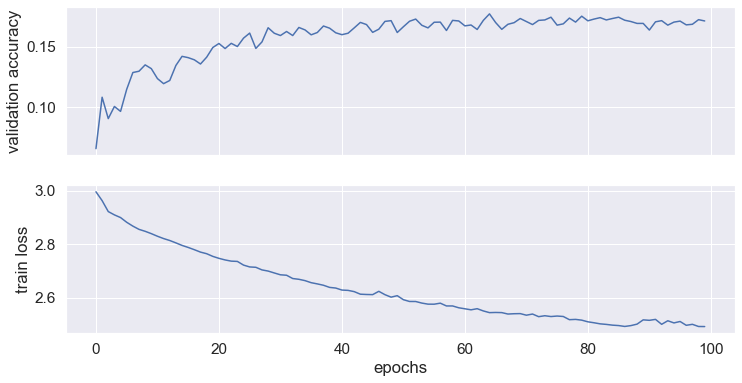

In [248]:

fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("train loss")
ax2.set_xlabel("epochs");

/Users/maxjansen/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


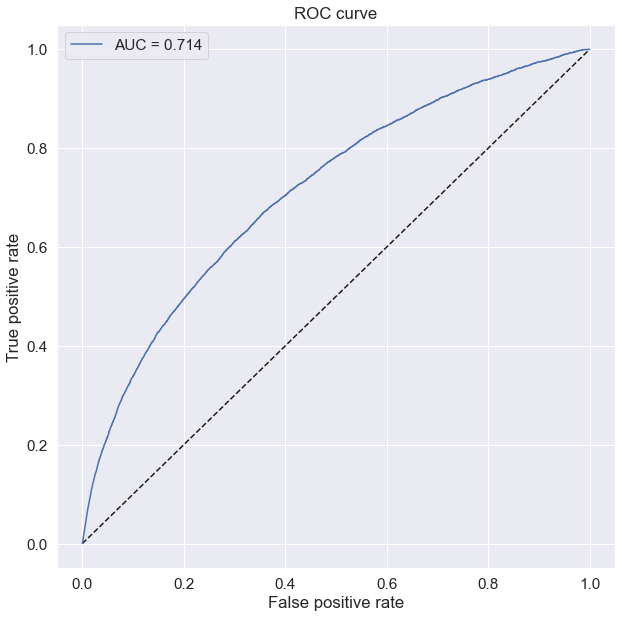

In [249]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

In [250]:
len(np.unique(y_test))

20

/Users/maxjansen/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/maxjansen/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/maxjansen/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/maxjansen/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/maxjansen/anacond

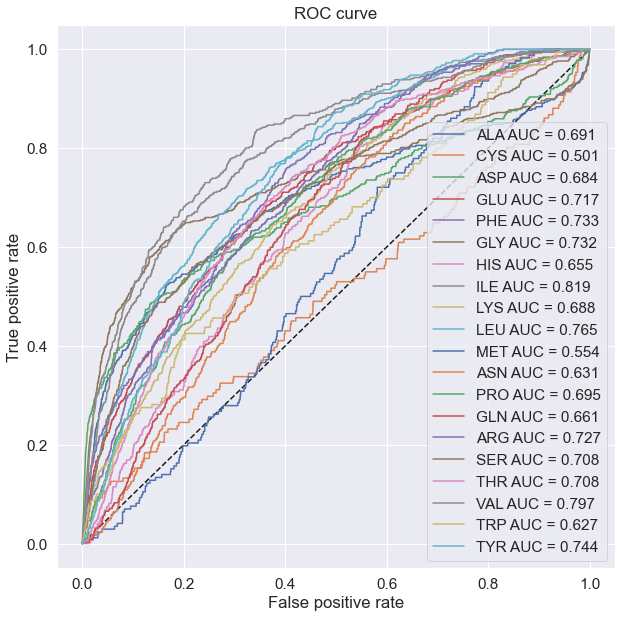

In [251]:
# Do a ROC plot for each amino acid
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()
for i in range(len(np.unique(y_test))):
    
    with torch.no_grad():
        y_pre = (model(X_test)[y_test == i]).numpy()
        Y_one = Y_onehot[y_test == i]
        fpr, tpr, threshold = roc_curve(Y_one.ravel(), y_pre.ravel())
    
    plt.plot(fpr, tpr, label=names[i] + ' AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

(8332, 20)

In [252]:
y_pred_max =np.zeros((len(y_pred),len(y_pred[0])))
for count,i in enumerate(y_pred):
    y_pred_max[count, np.argmax(i)] = 1

In [253]:
# One-hot to int
def onehot_int(one_hot):
    y_int = np.array([])
    for i in one_hot:
        y_int = np.concatenate((y_int, np.nonzero(i)[0]))
    return y_int

In [254]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(onehot_int(Y_onehot), onehot_int(y_pred_max))

In [255]:
def plot_confusion_matrix(data, labels):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    sns.set(color_codes=True)
    plt.figure(1, figsize=(14, 14))
 
    plt.title("Confusion Matrix")
 
    sns.set(font_scale=1.4)
    ax = sns.heatmap(data, annot=True, cmap="coolwarm", cbar_kws={'label': 'Scale'})
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")
    plt.close

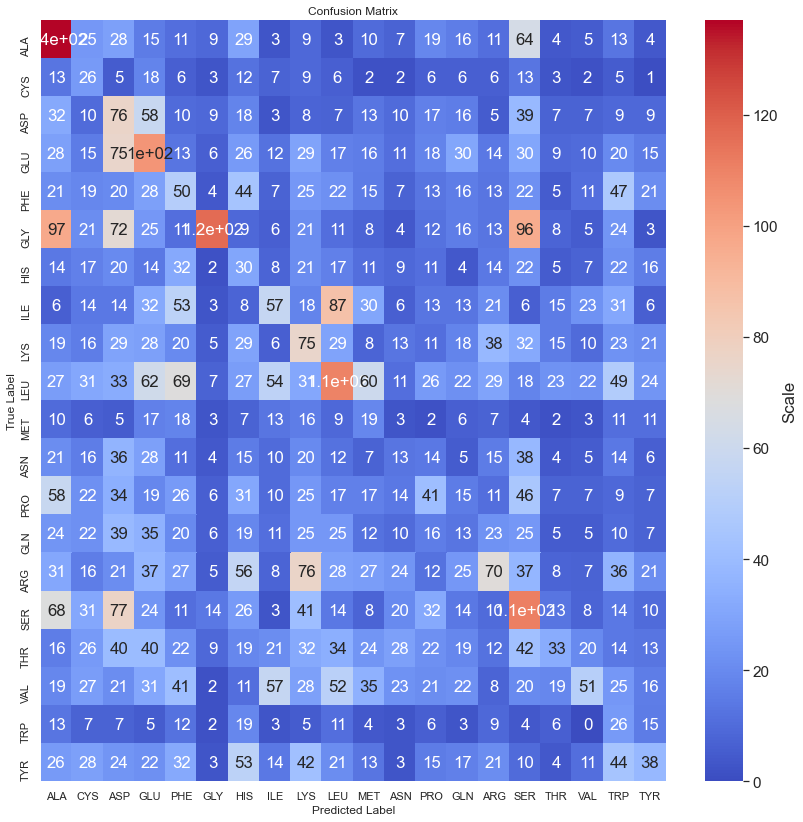

In [54]:
plot_confusion_matrix(cm, names)

In [208]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Conv1d(input_dim, 20, 1, stride=1)
        self.layer2 = nn.Linear(20, 30)
        self.layer3 = nn.AvgPool1d(30, stride=1)
        self.layer4 = nn.Linear(20, 20)


        
    def forward(self, x):
        x = torch.transpose(x, 1,2)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        #x = x.view(-1,20*20)
        x = F.relu(self.layer3(x))
        x = x.squeeze()
        x = F.sigmoid(self.layer4(x))
        
        return x
    
model     = Model(X_train.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn   = nn.CrossEntropyLoss(weight=res_weight)
model

Model(
  (layer1): Conv1d(28, 20, kernel_size=(1,), stride=(1,))
  (layer2): Linear(in_features=20, out_features=30, bias=True)
  (layer3): AvgPool1d(kernel_size=(30,), stride=(1,), padding=(0,))
  (layer4): Linear(in_features=20, out_features=20, bias=True)
)

In [ ]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(20, 10)
        self.layer2 = nn.Linear(280, 140)
        self.layer3 = nn.Linear(140, 20)


        
    def forward(self, x):
        #x = x.view(-1,20*28)
        x = F.relu(self.layer1(x))
        x = x.view(-1, 10*28)
        x = F.relu(self.layer2(x))
        x = F.sigmoid(self.layer3(x))
        
        return x

model     = Model(X_train.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn   = nn.CrossEntropyLoss(weight=res_weight)
model

In [209]:
input = X_train

In [210]:
output = model(input)

/Users/maxjansen/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [211]:
output.shape

torch.Size([33324, 20])

In [212]:
X_train.shape

torch.Size([33324, 20, 28])

In [ ]:
# Simple flattened NN, AUC = 0.71
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim*20, 280)
        self.layer2 = nn.Linear(280, 140)
        self.layer3 = nn.Linear(140, 20)


        
    def forward(self, x):
        x = x.view(-1,20*28)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.sigmoid(self.layer3(x))
        
        return x